在训练参数化机器学习模型时，权重衰减（weight decay）是最广泛使用的正则化的技术之一，它通常也被称为L2正则化。这项技术通过函数与零的距离来衡量函数的复杂度，因为在所有函数f中，函数f = 0（所有输入都得到值0）在某种意义上是最简单的。

对于λ = 0，我们恢复了原来的损失函数。对于λ > 0，我们限制∥w∥的大小。

使用L2范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。相比之下，L1惩罚会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。这称为特征选择（feature selection），这可能是其他场景下需要的。

与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。较小的λ值对应较少约束的w，而较大的λ值对w的约束更大。

是否对相应的偏置b^2进行惩罚在不同的实践中会有所不同，在神经网络的不同层中也会有所不同。通常，网络输出层的偏置项不会被正则化。

In [4]:
%matplotlib inline
import torch
from torch import nn
import random
from utils.fashion_mnist import *

In [6]:
# 高维线性回归
# 生成多项线性回归
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    # 生成均值为0标准差为1， num_examples * len(w)大小的张量
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 噪声
    return X, y.reshape((-1, 1))


n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [7]:
# 初始化模型
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [9]:
# 范数L2惩罚，每一项平方后求和
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [14]:
# 训练函数
def linear_regression(X, w, b):
    # Y = Xw + b线性回归模型
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() 

def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的模型的损失"""
    metric = Accumulator(2) # 损失总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(lambd): # lambda为正则化常数
    w, b = init_params()
    net, loss = lambda X: linear_regression(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                        xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                         evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 12.846026420593262


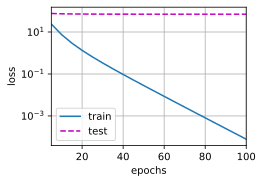

In [15]:
# lambda=0，禁用权重衰减
train(lambd=0)
# 训练误差减少，但是测试误差没有减少，说明出现了过拟合现象

w的L2范数是： 0.3879861831665039


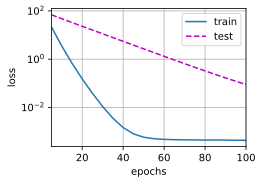

In [17]:
# 使用权重衰减
train(lambd=3)
# 训练误差增大，但是测试误差减小。这正是我们期望从正则化中得到的结果

### 简洁实现
在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。默认情况下，Py‐
Torch同时衰减权重和偏移。这里我们只为权重设置了weight_decay，所以偏置参数b不会衰减。

In [20]:
# 权重衰减的简洁实现，使用了pytorch自带的优化器权重衰减参数
# 这里只对权重设置衰减，而不衰减偏置参数
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    
    # 仅设置weight而不设置bias，偏置参数没有衰减
    trainer = torch.optim.SGD(
        [{"params":net[0].weight,'weight_decay': wd},
         {"params":net[0].bias}], 
        lr=lr)
    
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
            if (epoch + 1) % 5 == 0:
                animator.add(epoch + 1,
                             (evaluate_loss(net, train_iter, loss),
                              evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.695758819580078


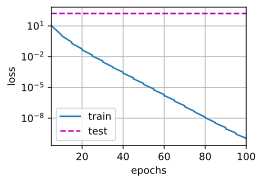

In [21]:
train_concise(0)

w的L2范数： 0.41946154832839966


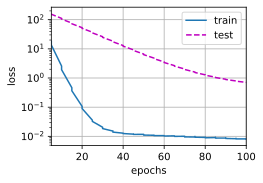

In [22]:
train_concise(3)

w的L2范数： 0.05513736233115196


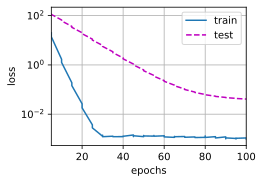

In [23]:
train_concise(5)

对于如何通过使用验证集找出最优的超参数，似乎需要列出一系列可选的超参数值，然后在验证集上进行训练，找到效果最好的超参数值。（？）